In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/n9455647/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
from DatasetManager import DatasetManager

import pandas as pd
import numpy as np

import os
import sys
from sys import argv
import pickle
import random
import joblib

import statistics
import math

import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dataset_ref = "bpic2012"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "single"
cls_encoding = "agg"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
max_feat = 10
max_prefix = 25

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['bpic2012_accepted']

Bucket 1
True Negatives
Average LIME Stability: 0.8150319713261649
Average SHAP Stability: 1.0


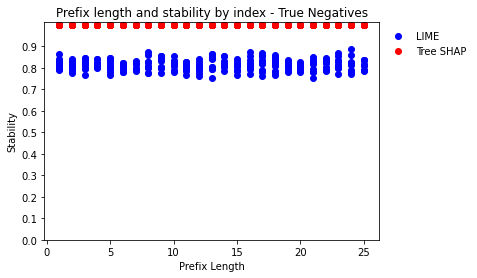

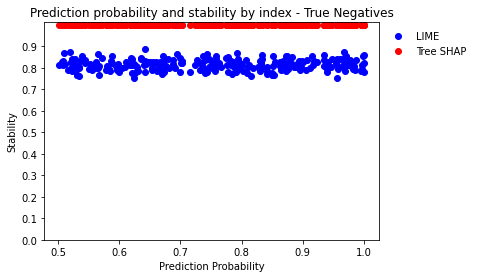

True Positives
Average LIME Stability: 0.8172124731182795
Average SHAP Stability: 1.0


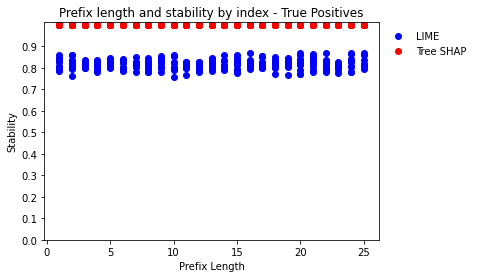

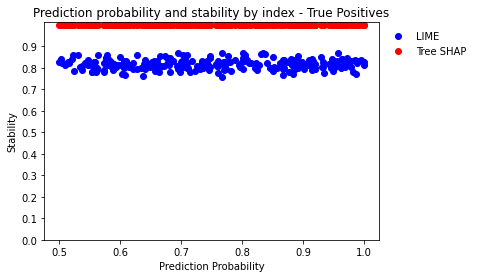

False Negatives
Average LIME Stability: 0.8130627956989247
Average SHAP Stability: 1.0


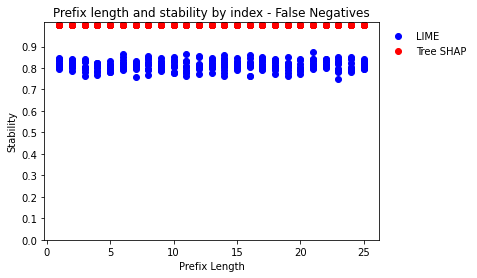

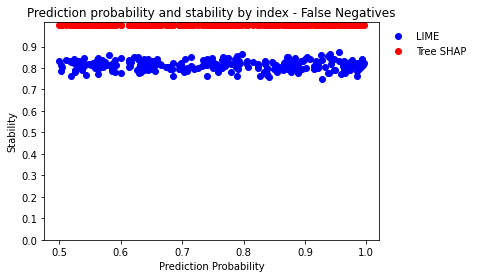

False Positives
Average LIME Stability: 0.813178064516129
Average SHAP Stability: 1.0


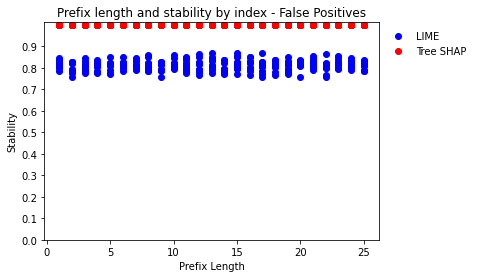

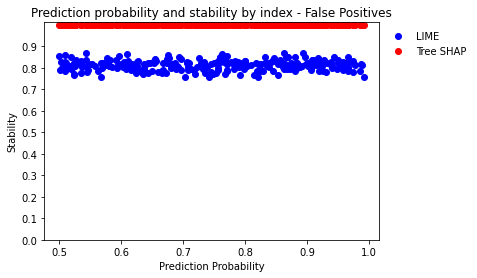

In [5]:
all_caseID = []
all_lengths = []
all_proba = []
all_lime_stab = []
all_shap_stab = []

for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
        
        #if num_buckets < max_prefix:
        #    max_prefix = num_buckets
            
        #buckets = range(0, max_prefix, gap)

        for bucket in range(num_buckets):
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            type_list = ["True Negatives", "True Positives", "False Negatives", "False Positives"]
            
            for i in range(len(sample_instances)):
                print (type_list[i])
                data = pd.DataFrame.from_records(sample_instances[i])
                
                case_id = pd.Series(data['caseID'])
                nr_events = pd.Series(data['nr_events'])
                proba = pd.Series(data['proba'])
                lime_stability = pd.Series(data['lime_stability'])
                tree_shap_stability = pd.Series(data['tree_shap_stability'])
                
                all_caseID.extend(case_id)
                all_lengths.extend(nr_events)
                all_proba.extend(proba)
                all_lime_stab.extend(lime_stability)
                all_shap_stab.extend(tree_shap_stability)
                
                print("Average LIME Stability:", statistics.mean(lime_stability))
                print("Average SHAP Stability:", statistics.mean(tree_shap_stability))
                
                fig, ax = plt.subplots()
                ax.plot(nr_events, lime_stability, 'bo', label = "LIME")
                ax.plot(nr_events, tree_shap_stability, 'ro', label = "Tree SHAP")
                ax.set_xlabel("Prefix Length")
                ax.set_ylabel("Stability")
                ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                plt.yticks(np.arange(0,1, 0.1))
                plt.title("Prefix length and stability by index - "+type_list[i])
                plt.show()
                
                fig2, ax2 = plt.subplots()
                ax2.plot(proba, lime_stability, 'bo', label = "LIME")
                ax2.plot(proba, tree_shap_stability, 'ro', label = "Tree SHAP")
                ax2.set_xlabel("Prediction Probability")
                ax2.set_ylabel("Stability")
                ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                plt.yticks(np.arange(0,1, 0.1))
                plt.title("Prediction probability and stability by index - "+type_list[i])
                plt.show()

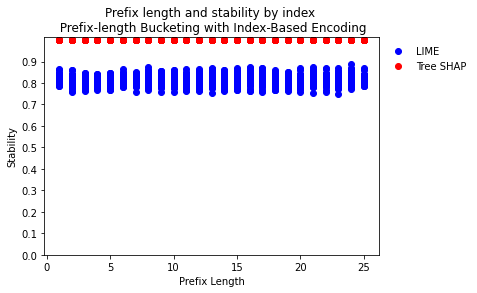

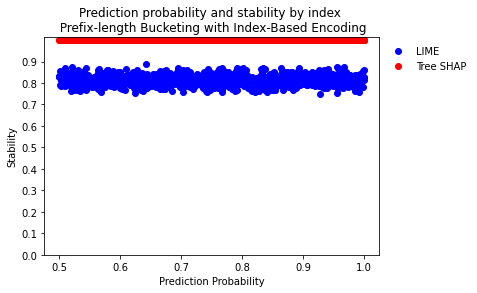

In [6]:
fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1, 0.1))
plt.title("Prefix length and stability by index \n Prefix-length Bucketing with Index-Based Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1, 0.1))
plt.title("Prediction probability and stability by index \n Prefix-length Bucketing with Index-Based Encoding")
plt.show()

Bucket 1
True Negatives
Average LIME Weights Stability: 0.135580800367917
Average SHAP Weights Stability: 1.0879561846742964e-16
250


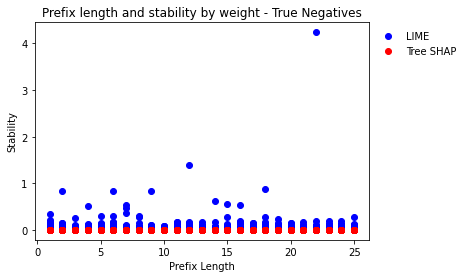

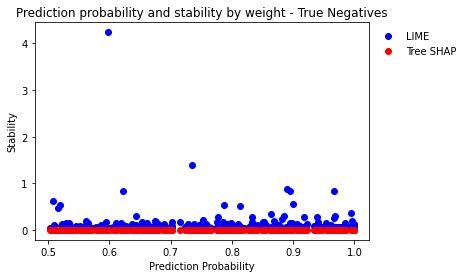

True Positives
Average LIME Weights Stability: 0.12692967919784334
Average SHAP Weights Stability: 1.1244795097583007e-16
250


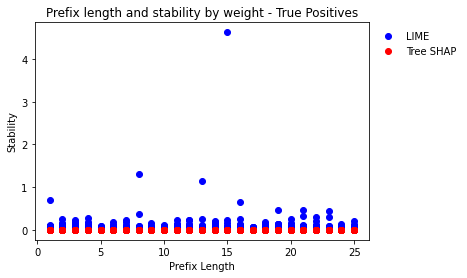

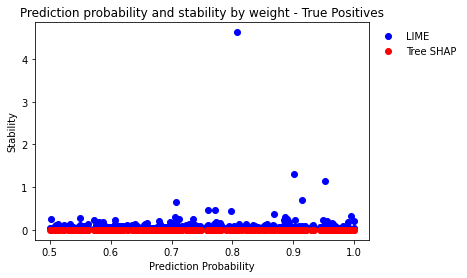

False Negatives
Average LIME Weights Stability: 0.1660601597488902
Average SHAP Weights Stability: 1.0564304324928286e-16
250


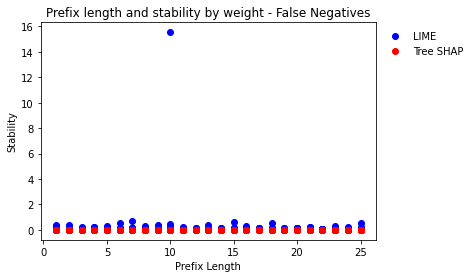

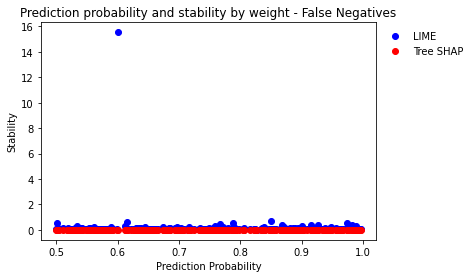

False Positives
Average LIME Weights Stability: 0.15290253049634459
Average SHAP Weights Stability: 1.0862217124694575e-16
250


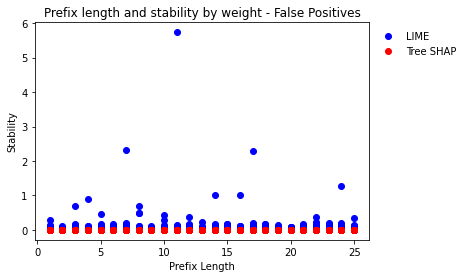

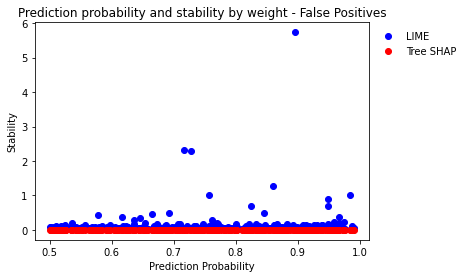

In [7]:
all_caseID = []
all_lengths = []
all_proba = []
all_lime_stab = []
all_shap_stab = []

for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
        
        #if num_buckets < max_prefix:
        #    max_prefix = num_buckets
            
        #buckets = range(0, max_prefix, gap)

        for bucket in range(num_buckets):
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            type_list = ["True Negatives", "True Positives", "False Negatives", "False Positives"]
            
            for i in range(len(sample_instances)):
                print (type_list[i])
                data = pd.DataFrame.from_records(sample_instances[i])
                
                dispersal_lime = []
                dispersal_shap = []
                adj_dispersal_lime = []
                adj_dispersal_shap = []
                
                case_id = pd.Series(data['caseID'])
                nr_events = pd.Series(data['nr_events'])
                proba = pd.Series(data['proba'])
                lime_stability = pd.Series(data['adjusted_lime_importance_stability'])
                tree_shap_stability = pd.Series(data['adjusted_shap_importance_stability'])
                
                all_caseID.extend(case_id)
                all_lengths.extend(nr_events)
                all_proba.extend(proba)
                all_lime_stab.extend(lime_stability)
                all_shap_stab.extend(tree_shap_stability)
                
                print("Average LIME Weights Stability:", statistics.mean(lime_stability))
                print("Average SHAP Weights Stability:", statistics.mean(tree_shap_stability))
                
                shap_dispersion = [disp for disp in tree_shap_stability if disp > 0]
                
                print (len(shap_dispersion))
                
                fig, ax = plt.subplots()
                ax.plot(nr_events, lime_stability, 'bo', label = "LIME")
                ax.plot(nr_events, tree_shap_stability, 'ro', label = "Tree SHAP")
                ax.set_xlabel("Prefix Length")
                ax.set_ylabel("Stability")
                ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                plt.title("Prefix length and stability by weight - "+type_list[i])
                plt.show()
                
                fig2, ax2 = plt.subplots()
                ax2.plot(proba, lime_stability, 'bo', label = "LIME")
                ax2.plot(proba, tree_shap_stability, 'ro', label = "Tree SHAP")
                ax2.set_xlabel("Prediction Probability")
                ax2.set_ylabel("Stability")
                ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                plt.title("Prediction probability and stability by weight - "+type_list[i])
                plt.show()

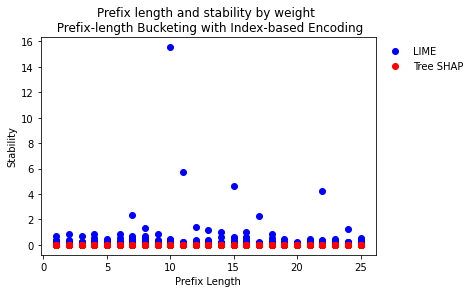

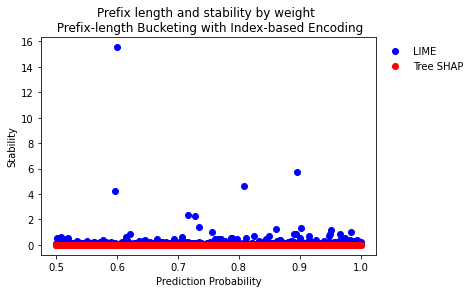

In [8]:
fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and stability by weight \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and stability by weight \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

In [9]:
lime_mean = np.mean(all_lime_stab)
lime_std = np.std(all_lime_stab)
lime_upper = lime_mean + (3*lime_std)
lime_lower = lime_mean - (3*lime_std)

shap_mean = np.mean(all_shap_stab)
shap_std = np.std(all_shap_stab)
shap_upper = shap_mean + (3*shap_std)
shap_lower = shap_mean - (3*shap_std)

lime_outliers = [i for i in all_lime_stab if i > lime_upper or i < lime_lower]
shap_outliers = [i for i in all_shap_stab if i > shap_upper or i < shap_lower]

print (lime_mean)
print (shap_mean)
print(len(lime_outliers))
print(len(shap_outliers))
print(str(len(lime_outliers)/len(all_lime_stab)*100)+"%")
print(str(len(shap_outliers)/len(all_shap_stab)*100)+"%")

0.1453682924527488
1.0887719598487206e-16
6
9
0.6%
0.8999999999999999%


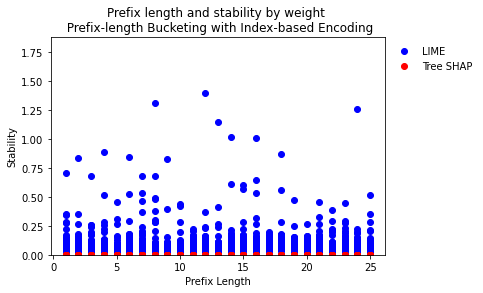

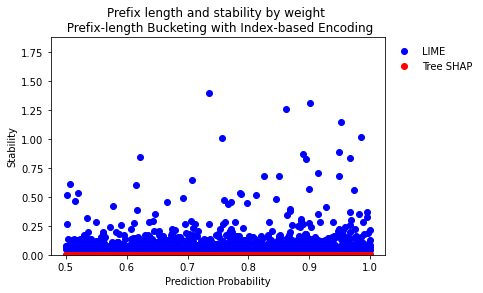

In [10]:
fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.ylim(0, lime_upper)
plt.title("Prefix length and stability by weight \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.ylim(0, lime_upper)
plt.title("Prefix length and stability by weight \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

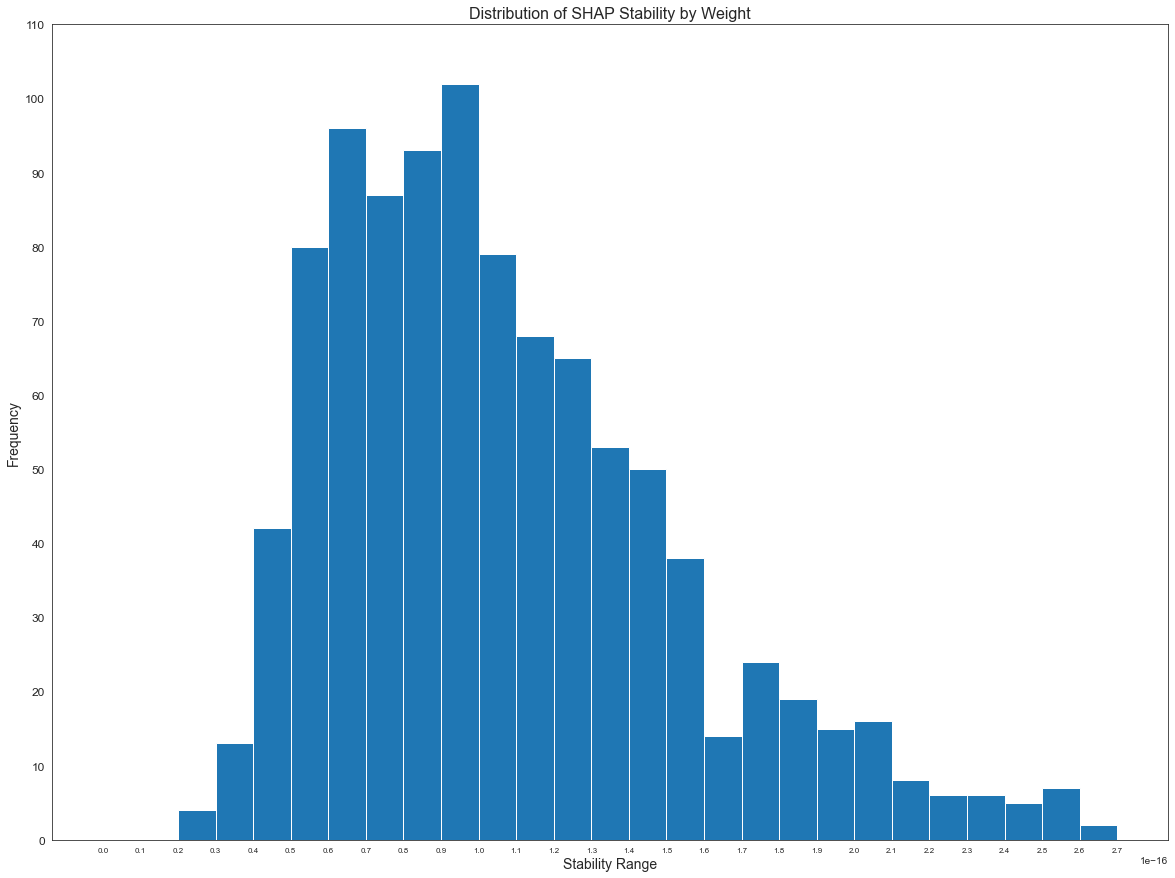

In [11]:
bins = np.arange(0, shap_upper+1e-17, 1e-17)
yticks = np.arange(0, 120, 10)
sns.set_style("white")
plt.subplots(figsize=(20, 15))
plt.hist(all_shap_stab, bins = bins)
#plt.figsize([50, 50])
plt.xticks(bins, fontsize = 8)
plt.yticks(yticks, fontsize = 12)
plt.title("Distribution of SHAP Stability by Weight", fontsize = 16)
plt.xlabel("Stability Range", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.show()

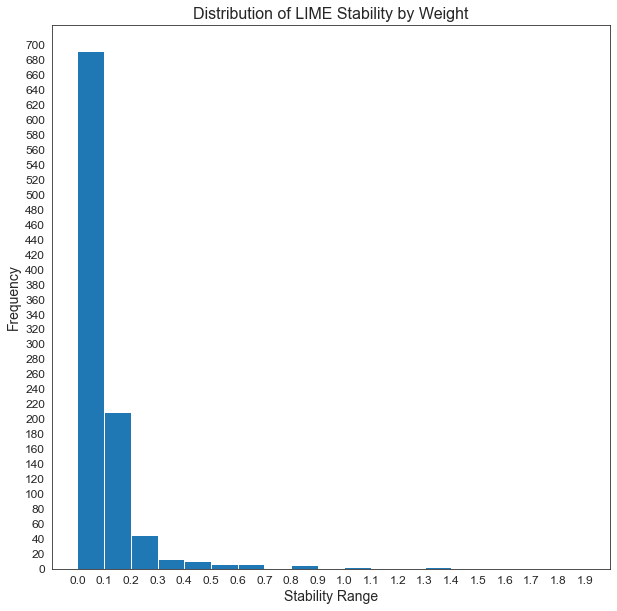

In [29]:
bins = np.arange(0, lime_upper+0.1, 0.1)
yticks = np.arange(0, 720, 20)
sns.set_style("white")
plt.subplots(figsize=(10, 10))
plt.hist(all_lime_stab, bins = bins)
#plt.figsize([50, 50])
plt.xticks(bins, fontsize = 12)
plt.yticks(yticks, fontsize = 12)
plt.title("Distribution of LIME Stability by Weight", fontsize = 16)
plt.xlabel("Stability Range", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.show()

In [13]:
all_caseID = []
all_lengths = []
all_proba = []

sep_caseID = [[],[],[],[]]
sep_lengths = [[],[],[],[]]
sep_proba = [[],[],[],[]]

all_lime_diffs = []
all_shap_diffs = []

sep_lime_diffs = [[],[],[],[]]
sep_shap_diffs = [[],[],[],[]]

all_lime_MSE = []
all_lime_RMSE = []
all_lime_MAE = []
all_lime_MAPE = []

sep_lime_MSE = [[],[],[],[]]
sep_lime_RMSE = [[],[],[],[]]
sep_lime_MAE = [[],[],[],[]]
sep_lime_MAPE = [[],[],[],[]]

all_shap_MSE = []
all_shap_RMSE = []
all_shap_MAE = []
all_shap_MAPE = []

sep_shap_MSE = [[],[],[],[]]
sep_shap_RMSE = [[],[],[],[]]
sep_shap_MAE = [[],[],[],[]]
sep_shap_MAPE = [[],[],[],[]]

for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
        
        #if num_buckets < max_prefix:
        #    max_prefix = num_buckets
            
        #buckets = range(0, max_prefix, gap)

        for bucket in range(num_buckets):
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            type_list = ["True Negatives", "True Positives", "False Negatives", "False Positives"]
            
            for i in range(len(sample_instances)):
                print (type_list[i])
                data = pd.DataFrame.from_records(sample_instances[i])
                
                lime_MSE = []
                lime_RMSE = []
                lime_MAE = []
                lime_MAPE = []
                
                shap_MSE = []
                shap_RMSE = []
                shap_MAE = []
                shap_MAPE = []
                
                case_id = pd.Series(data['caseID'])
                nr_events = pd.Series(data['nr_events'])
                proba = pd.Series(data['proba'])
                lime_diffs = pd.Series(data['lime_fid_change'])
                shap_diffs = pd.Series(data['shap_fid_change'])
                
                for j in range(len(lime_diffs)):
                    p1 = proba[j]
                    
                    lime_diff = lime_diffs[j]
                    shap_diff = shap_diffs[j]
                    
                    all_lime_diffs.append(lime_diff)
                    all_shap_diffs.append(shap_diff)
                    
                    lime_sq_changes = []
                    lime_abs_changes = []
                    lime_rel_changes = []
                    
                    shap_sq_changes = []
                    shap_abs_changes = []
                    shap_rel_changes = []
                    
                    for each in lime_diff:
                        lime_sq_changes.append(each**2)
                        lime_abs_changes.append(abs(each))
                        lime_rel_changes.append(abs(each)/p1)
                        
                    for each in shap_diff:
                        shap_sq_changes.append(each**2)
                        shap_abs_changes.append(abs(each))
                        shap_rel_changes.append(abs(each)/p1)
                    
                    lime_MSE.append(sum(lime_sq_changes)/len(lime_sq_changes))
                    lime_RMSE.append(math.sqrt(sum(lime_sq_changes)/len(lime_sq_changes)))
                    lime_MAE.append(sum(lime_abs_changes)/len(lime_abs_changes))
                    lime_MAPE.append(sum(lime_rel_changes)/len(lime_rel_changes))
                    
                    shap_MSE.append(sum(shap_sq_changes)/len(shap_sq_changes))
                    shap_RMSE.append(math.sqrt(sum(shap_sq_changes)/len(shap_sq_changes)))
                    shap_MAE.append(sum(shap_abs_changes)/len(shap_abs_changes))
                    shap_MAPE.append(sum(shap_rel_changes)/len(shap_rel_changes))
                
                all_caseID.extend(case_id)
                all_lengths.extend(nr_events)
                all_proba.extend(proba)
                
                all_lime_MSE.extend(lime_MSE)
                all_lime_RMSE.extend(lime_RMSE)
                all_lime_MAE.extend(lime_MAE)
                all_lime_MAPE.extend(lime_MAPE)
                
                all_shap_MSE.extend(shap_MSE)
                all_shap_RMSE.extend(shap_RMSE)
                all_shap_MAE.extend(shap_MAE)
                all_shap_MAPE.extend(shap_MAPE)
                
                sep_caseID[i].extend(case_id)
                sep_lengths[i].extend(nr_events)
                sep_proba[i].extend(proba)
                
                sep_lime_MSE[i].extend(lime_MSE)
                sep_lime_RMSE[i].extend(lime_RMSE)
                sep_lime_MAE[i].extend(lime_MAE)
                sep_lime_MAPE[i].extend(lime_MAPE)
                
                sep_shap_MSE[i].extend(shap_MSE)
                sep_shap_RMSE[i].extend(shap_RMSE)
                sep_shap_MAE[i].extend(shap_MAE)
                sep_shap_MAPE[i].extend(shap_MAPE)
                
                print("Average LIME MSE:", statistics.mean(lime_MSE))
                print("Average SHAP MSE:", statistics.mean(shap_MSE))
                print("\n")
                
                #plt.plot(nr_events, lime_MSE, 'bo', label = "LIME")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prefix length and MSE \n"+type_list[i])
                #plt.show()

                #plt.plot(nr_events, shap_MSE, 'ro', label = "Tree SHAP")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                ##plt.yticks(np.arange(0,15,1))
                #plt.title("Prefix length and MSE \n"+type_list[i])
                #plt.show()

                #plt.plot(proba, lime_MSE, 'bo', label = "LIME")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prediction probability and MSE \n"+type_list[i])
                #plt.show()

                #plt.plot(proba, shap_MSE, 'ro', label = "Tree SHAP")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prediction probability and MSE \n"+type_list[i])
                #plt.show()
                
                print("Average LIME RMSE:", statistics.mean(lime_RMSE))
                print("Average SHAP RMSE:", statistics.mean(shap_RMSE))
                print("\n")
                
                #plt.plot(nr_events, lime_RMSE, 'bo', label = "LIME")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prefix length and RMSE \n"+type_list[i])
                #plt.show()

                #plt.plot(nr_events, shap_RMSE, 'ro', label = "Tree SHAP")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prefix length and RMSE \n"+type_list[i])
                #plt.show()

                #plt.plot(proba, lime_RMSE, 'bo', label = "LIME")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prediction probability and RMSE \n"+type_list[i])
                #plt.show()

                #plt.plot(proba, shap_RMSE, 'ro', label = "Tree SHAP")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prediction probability and RMSE \n"+type_list[i])
                #plt.show()
                
                print("Average LIME MAE:", statistics.mean(lime_MAE))
                print("Average SHAP MAE:", statistics.mean(shap_MAE))
                print("\n")
                
                #plt.plot(nr_events, lime_MAE, 'bo', label = "LIME")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prefix length and MAE \n"+type_list[i])
                #plt.show()

                #plt.plot(nr_events, shap_MAE, 'ro', label = "Tree SHAP")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prefix length and MAE \n"+type_list[i])
                #plt.show()

                #plt.plot(proba, lime_MAE, 'bo', label = "LIME")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prediction probability and MAE \n"+type_list[i])
                #plt.show()

                #plt.plot(proba, shap_MAE, 'ro', label = "Tree SHAP")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prediction probability and MAE \n"+type_list[i])
                #plt.show()
                
                print("Average LIME MAPE:", statistics.mean(lime_MAPE))
                print("Average SHAP MAPE:", statistics.mean(shap_MAPE))
                print("\n")
                
                #plt.plot(nr_events, lime_MAPE, 'bo', label = "LIME")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prefix length and MAPE \n"+type_list[i])
                #plt.show()

                #plt.plot(nr_events, shap_MAPE, 'ro', label = "Tree SHAP")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prefix length and MAPE \n"+type_list[i])
                #plt.show()

                #plt.plot(proba, lime_MAPE, 'bo', label = "LIME")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prediction probability and MAPE \n"+type_list[i])
                #plt.show()

                #plt.plot(proba, shap_MAPE, 'ro', label = "Tree SHAP")
                #plt.xlabel("Prefix Length")
                #plt.ylabel("Change in Prediction Probability")
                #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,15,1))
                #plt.title("Prediction probability and MAPE \n"+type_list[i])
                #plt.show()

Bucket 1
True Negatives
Average LIME MSE: 0.12025978639462832
Average SHAP MSE: 0.19584280042396796


Average LIME RMSE: 0.3156659368508828
Average SHAP RMSE: 0.3819872926254293


Average LIME MAE: 0.24835571262820158
Average SHAP MAE: 0.37617153487934263


Average LIME MAPE: 0.3339759523776749
Average SHAP MAPE: 0.49480208863536285


True Positives
Average LIME MSE: 0.17698157249863022
Average SHAP MSE: 0.23059621724575707


Average LIME RMSE: 0.38383117119923316
Average SHAP RMSE: 0.4231102947653692


Average LIME MAE: 0.3341397371053696
Average SHAP MAE: 0.4164996839046478


Average LIME MAPE: 0.435796058186055
Average SHAP MAPE: 0.5408225717248358


False Negatives
Average LIME MSE: 0.10605178263620378
Average SHAP MSE: 0.19301961374813711


Average LIME RMSE: 0.3038305006111239
Average SHAP RMSE: 0.38327899486270117


Average LIME MAE: 0.2303669156972319
Average SHAP MAE: 0.3772051622651517


Average LIME MAPE: 0.31395844569767084
Average SHAP MAPE: 0.49390859141301413


False Pos

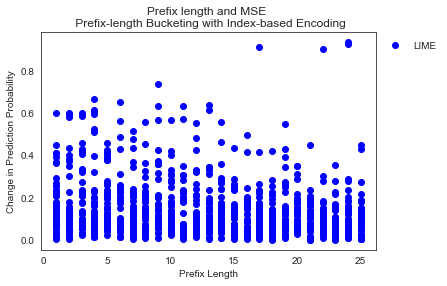

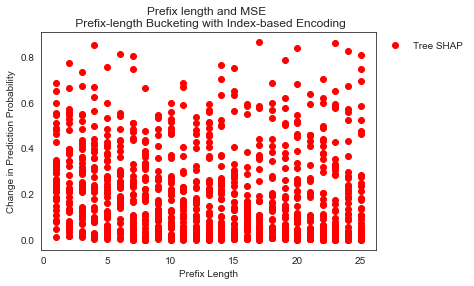

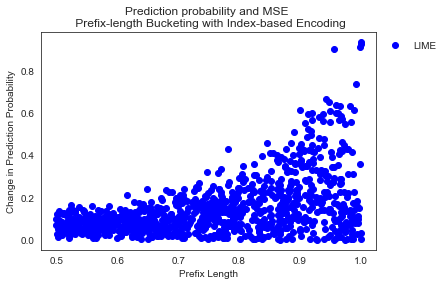

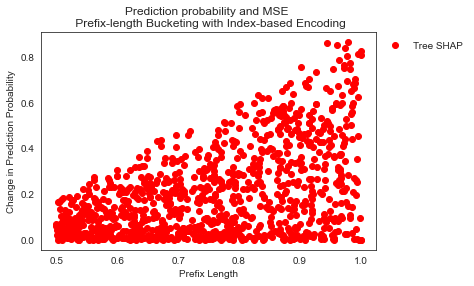

In [14]:
plt.plot(all_lengths, all_lime_MSE, 'bo', label = "LIME")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and MSE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_lengths, all_shap_MSE, 'ro', label = "Tree SHAP")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and MSE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_proba, all_lime_MSE, 'bo', label = "LIME")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and MSE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_proba, all_shap_MSE, 'ro', label = "Tree SHAP")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and MSE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

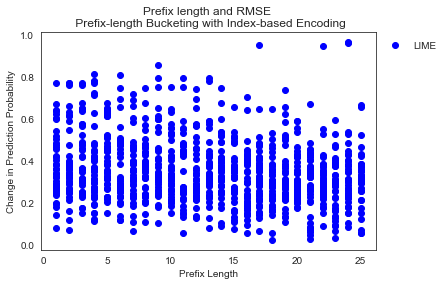

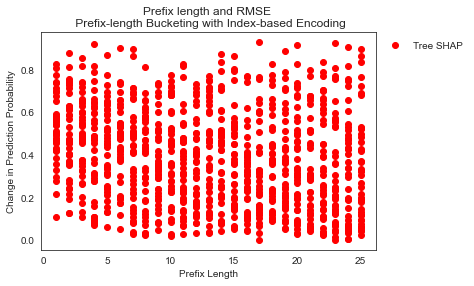

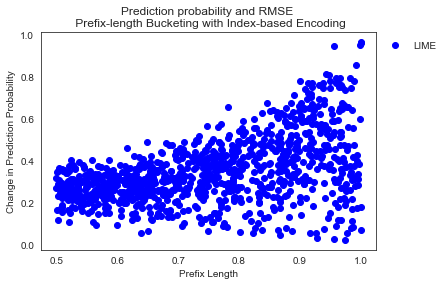

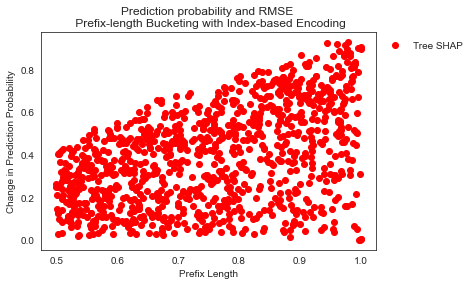

In [15]:
plt.plot(all_lengths, all_lime_RMSE, 'bo', label = "LIME")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and RMSE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_lengths, all_shap_RMSE, 'ro', label = "Tree SHAP")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and RMSE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_proba, all_lime_RMSE, 'bo', label = "LIME")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and RMSE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_proba, all_shap_RMSE, 'ro', label = "Tree SHAP")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and RMSE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

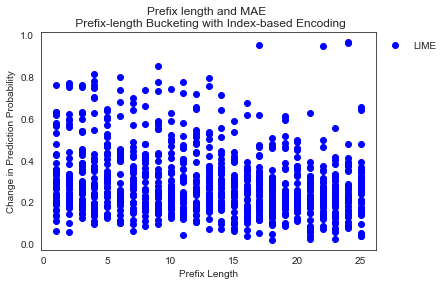

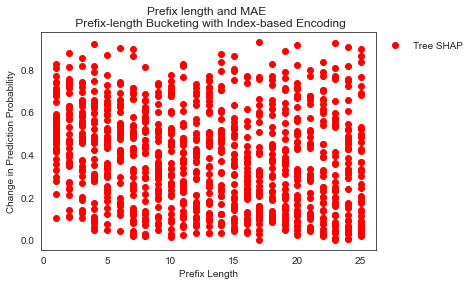

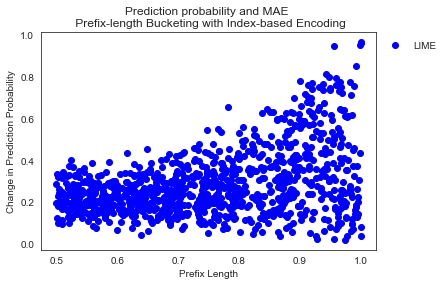

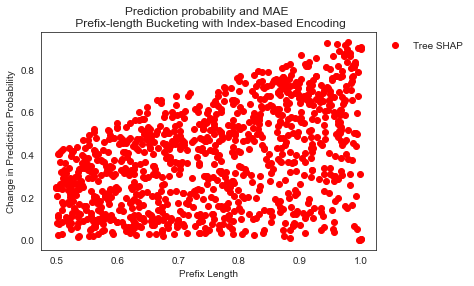

In [16]:
plt.plot(all_lengths, all_lime_MAE, 'bo', label = "LIME")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and MAE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_lengths, all_shap_MAE, 'ro', label = "Tree SHAP")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and MAE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_proba, all_lime_MAE, 'bo', label = "LIME")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and MAE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_proba, all_shap_MAE, 'ro', label = "Tree SHAP")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and MAE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

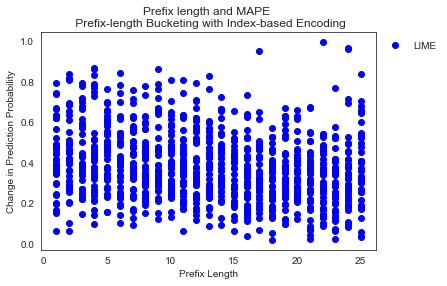

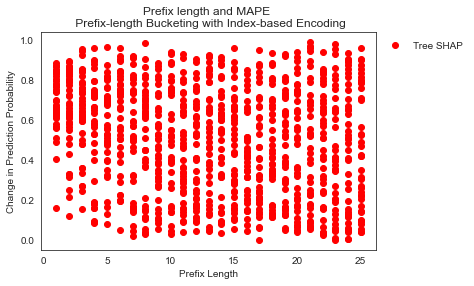

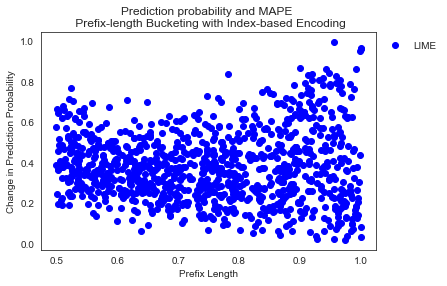

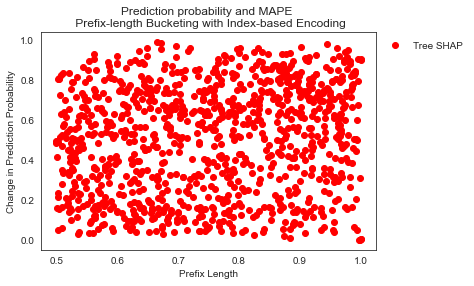

In [17]:
plt.plot(all_lengths, all_lime_MAPE, 'bo', label = "LIME")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and MAPE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_lengths, all_shap_MAPE, 'ro', label = "Tree SHAP")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and MAPE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_proba, all_lime_MAPE, 'bo', label = "LIME")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and MAPE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

plt.plot(all_proba, all_shap_MAPE, 'ro', label = "Tree SHAP")
plt.xlabel("Prefix Length")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and MAPE \n Prefix-length Bucketing with Index-based Encoding")
plt.show()

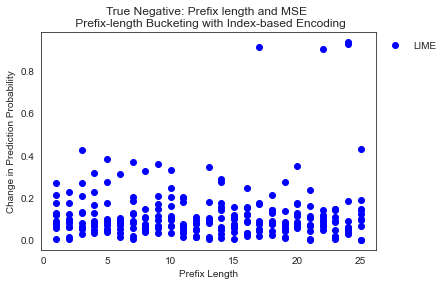

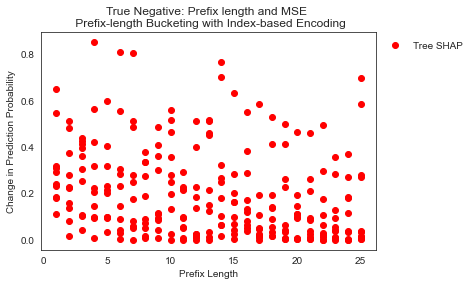

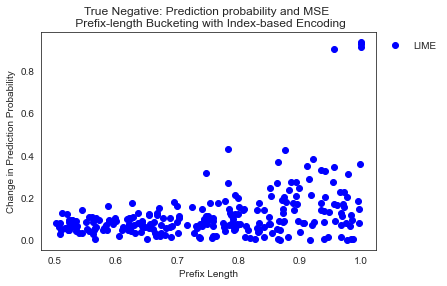

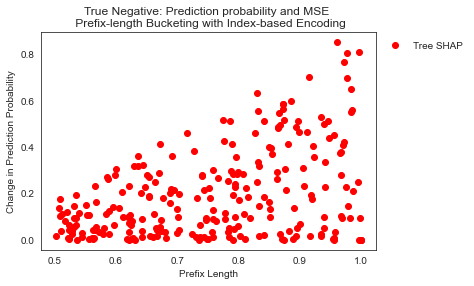

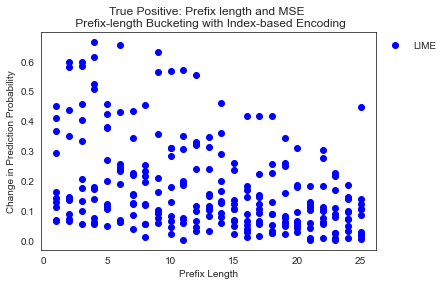

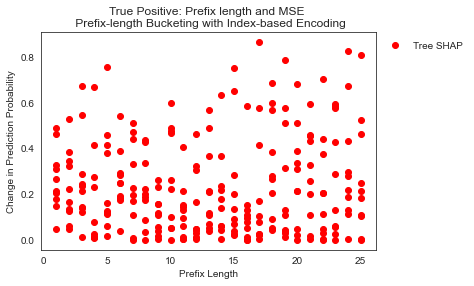

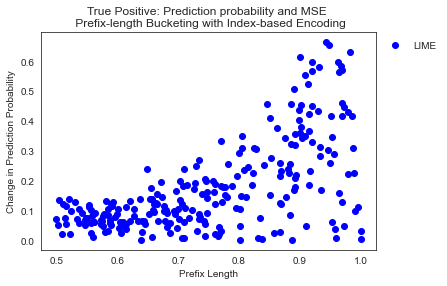

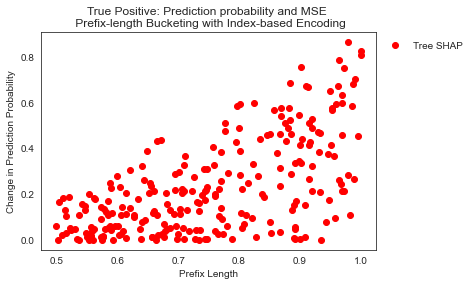

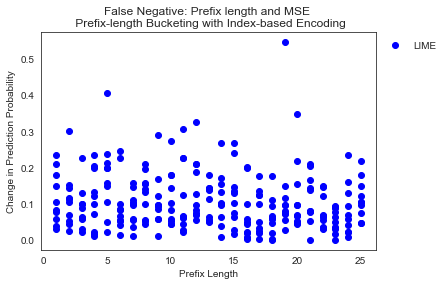

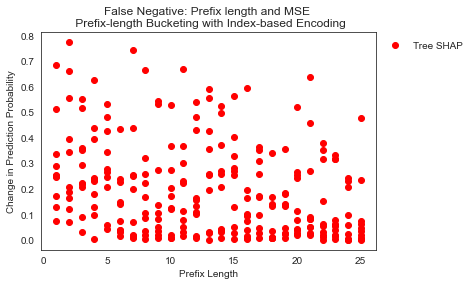

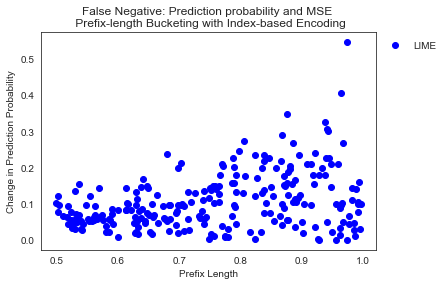

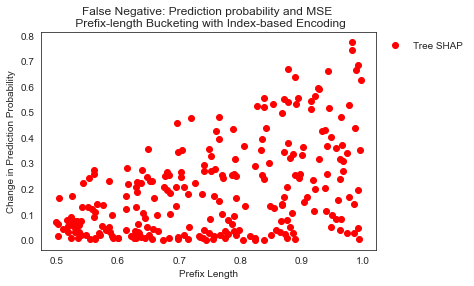

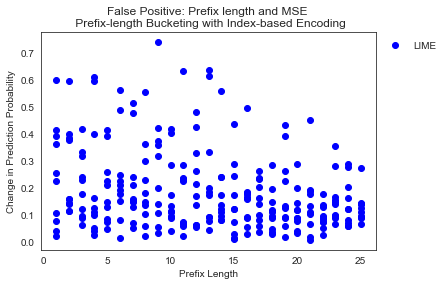

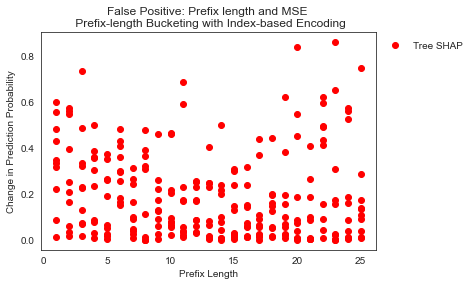

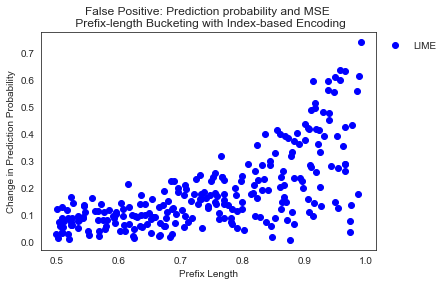

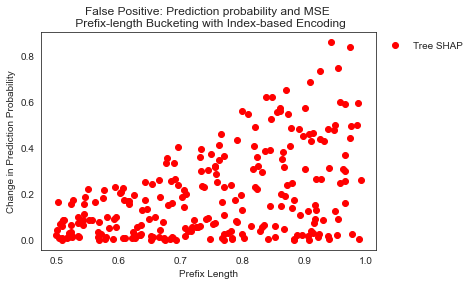

In [18]:
type_list = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for i in range(len(type_list)):
    plt.plot(sep_lengths[i], sep_lime_MSE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_lengths[i], sep_shap_MSE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_proba[i], sep_lime_MSE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_proba[i], sep_shap_MSE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

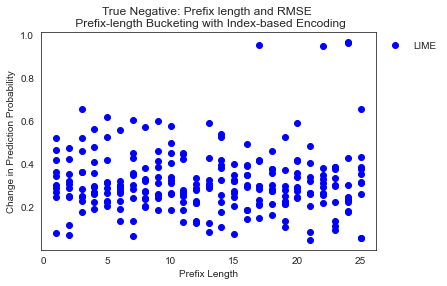

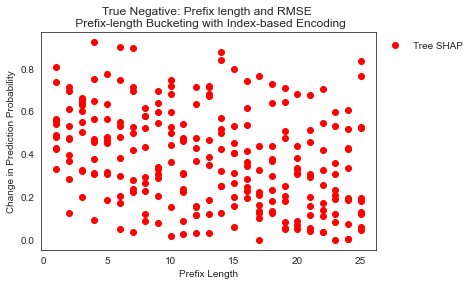

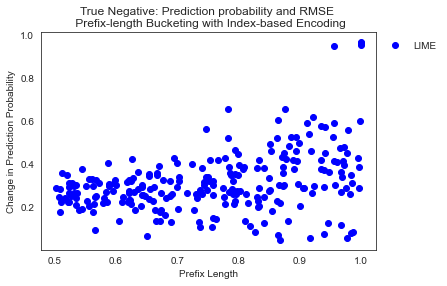

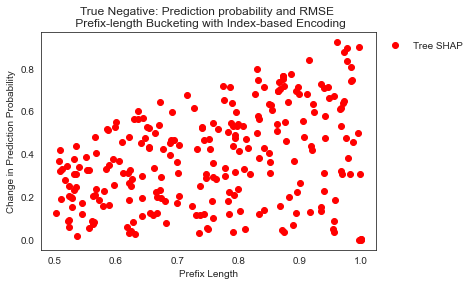

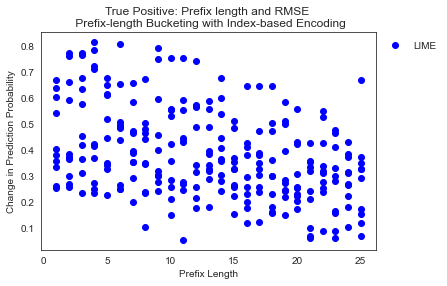

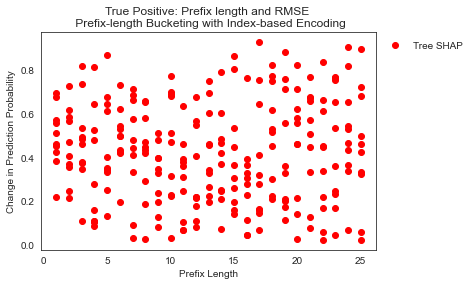

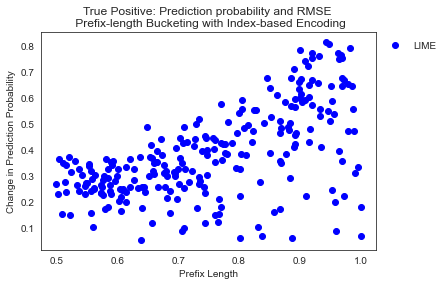

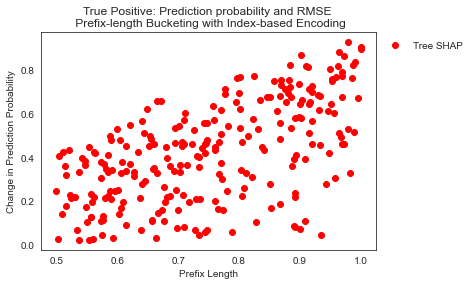

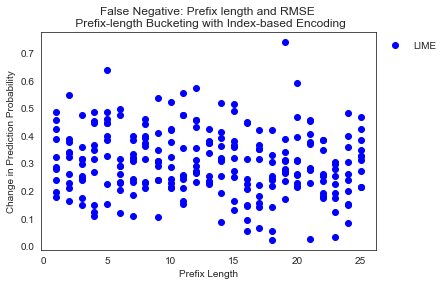

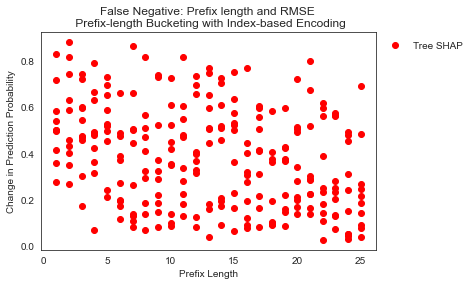

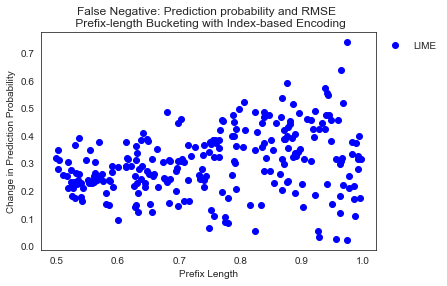

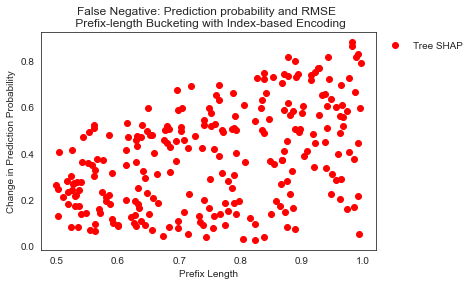

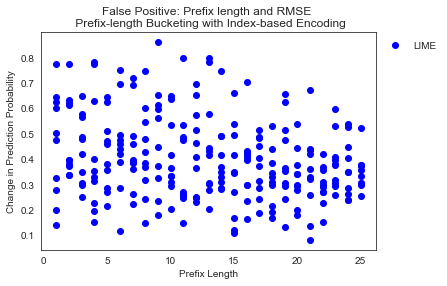

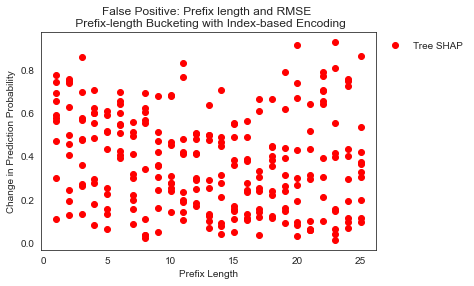

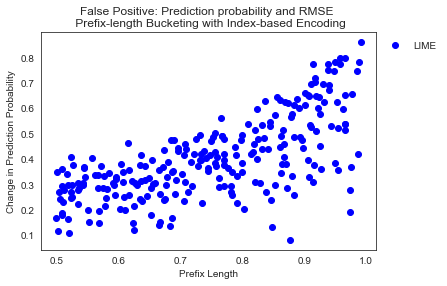

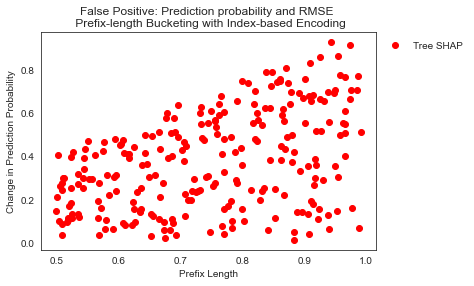

In [19]:
type_list = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for i in range(len(type_list)):
    plt.plot(sep_lengths[i], sep_lime_RMSE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and RMSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_lengths[i], sep_shap_RMSE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and RMSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_proba[i], sep_lime_RMSE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and RMSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_proba[i], sep_shap_RMSE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and RMSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

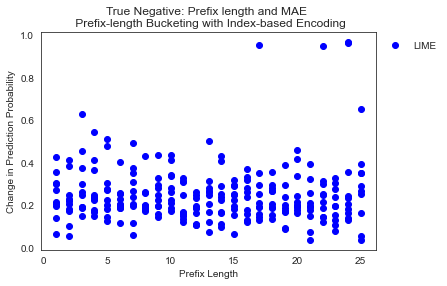

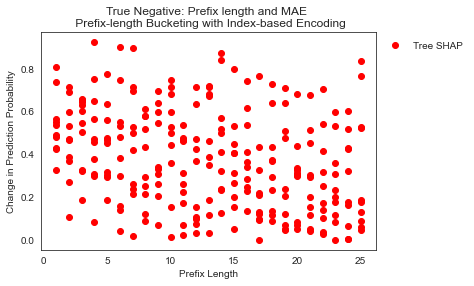

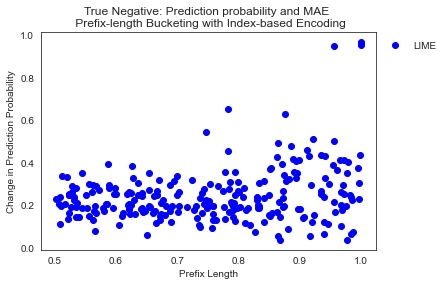

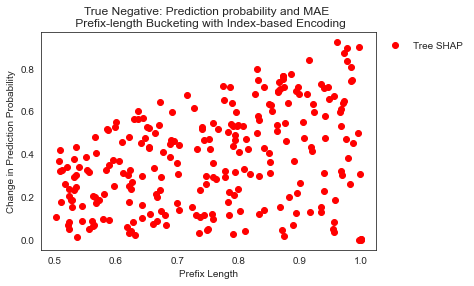

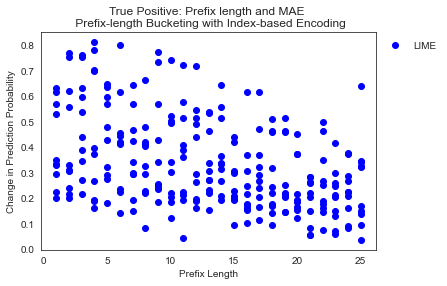

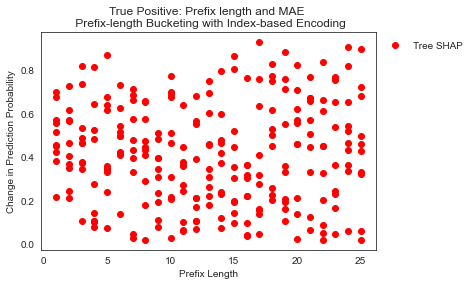

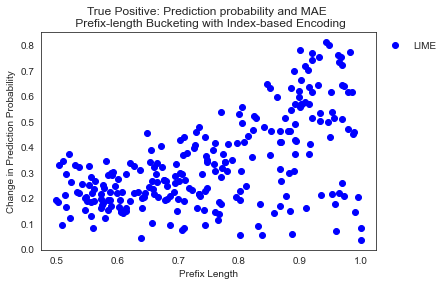

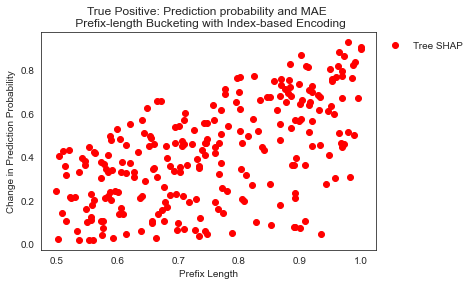

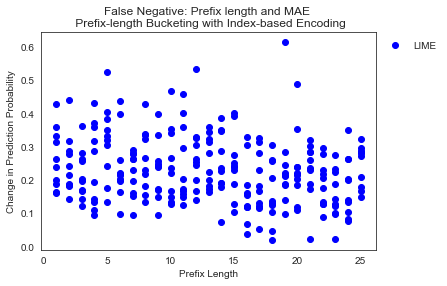

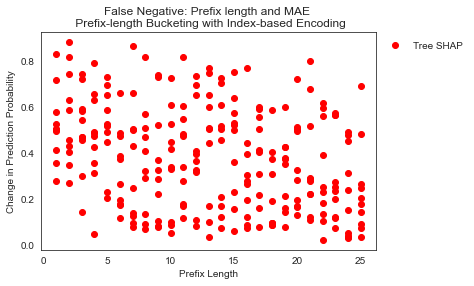

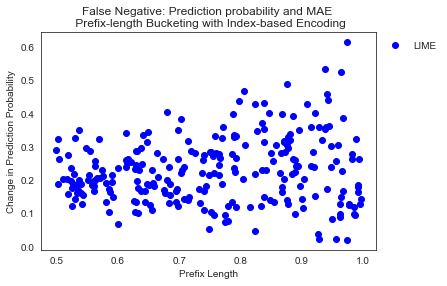

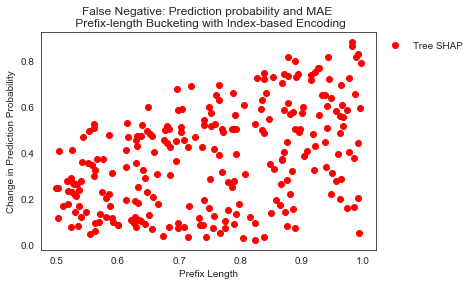

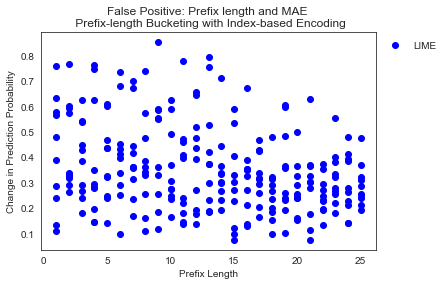

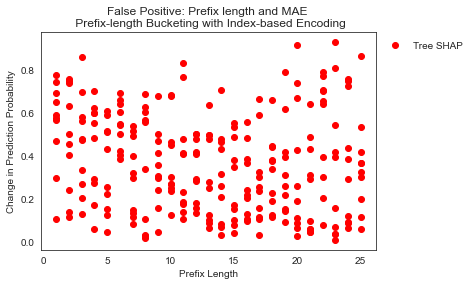

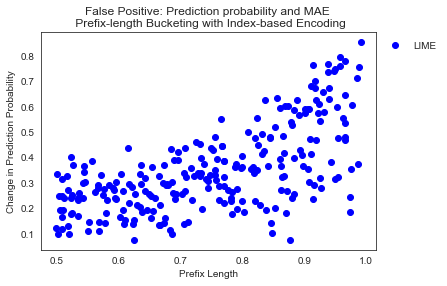

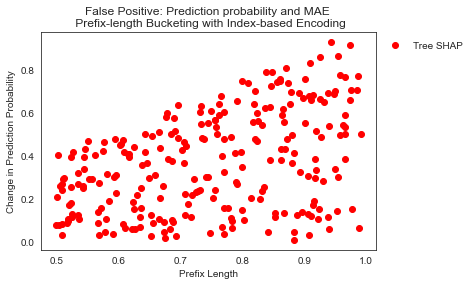

In [20]:
type_list = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for i in range(len(type_list)):
    plt.plot(sep_lengths[i], sep_lime_MAE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MAE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_lengths[i], sep_shap_MAE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MAE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_proba[i], sep_lime_MAE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MAE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_proba[i], sep_shap_MAE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MAE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

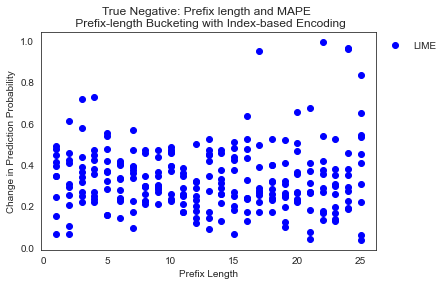

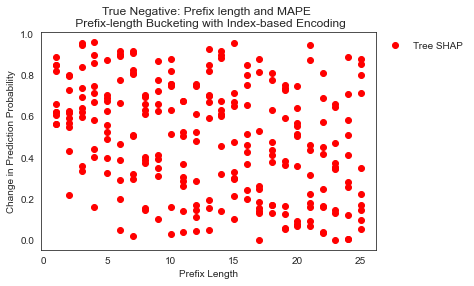

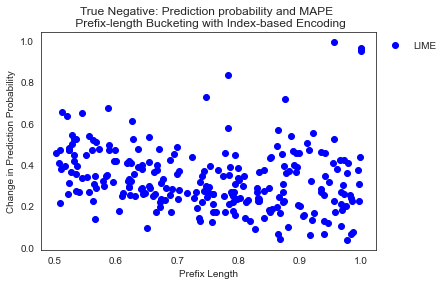

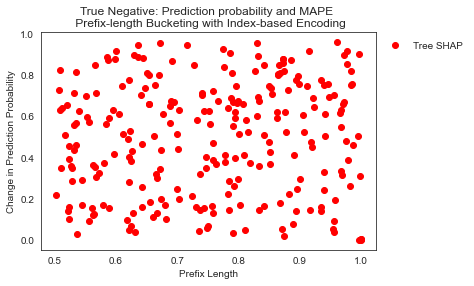

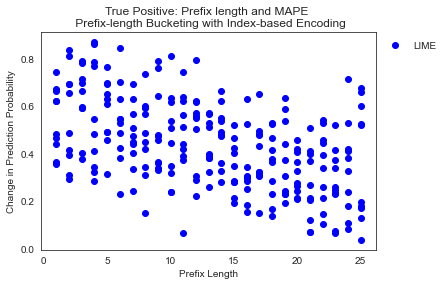

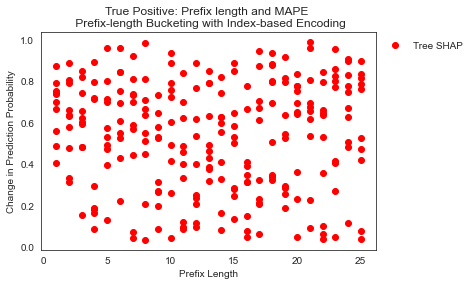

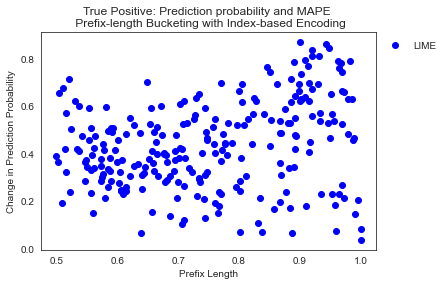

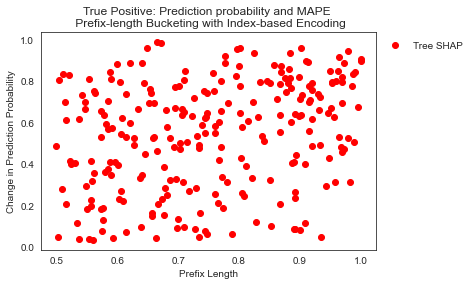

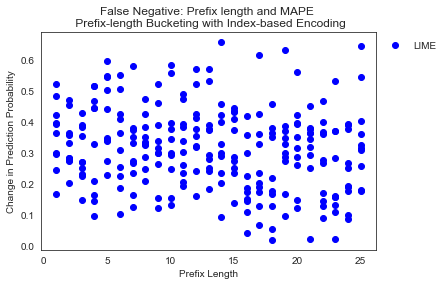

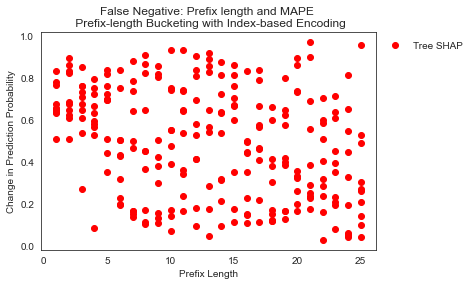

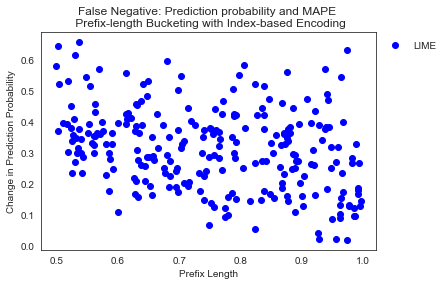

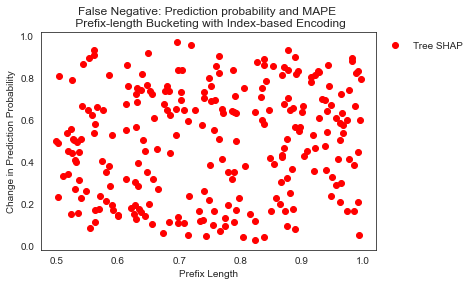

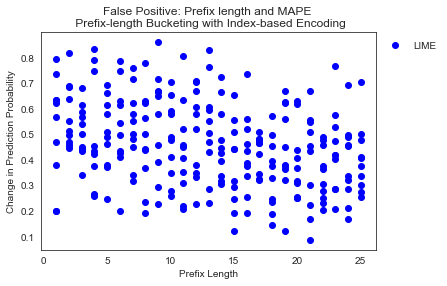

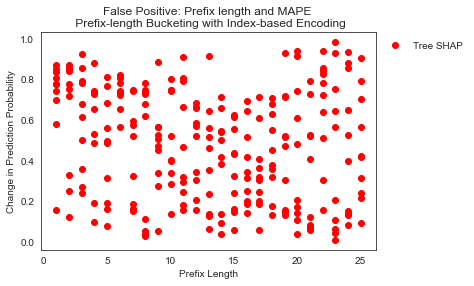

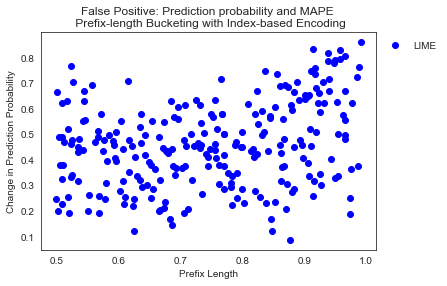

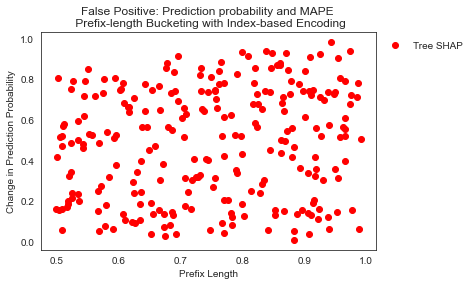

In [21]:
type_list = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for i in range(len(type_list)):
    plt.plot(sep_lengths[i], sep_lime_MAPE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MAPE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_lengths[i], sep_shap_MAPE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MAPE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_proba[i], sep_lime_MAPE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MAPE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(sep_proba[i], sep_shap_MAPE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MAPE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

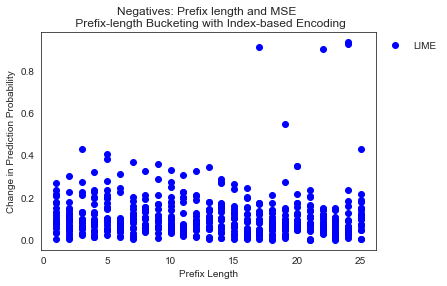

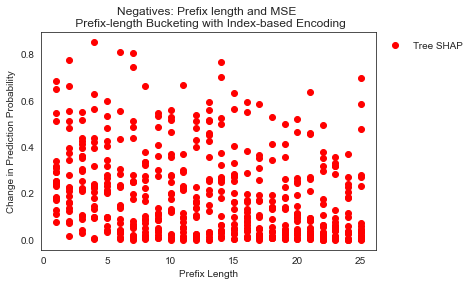

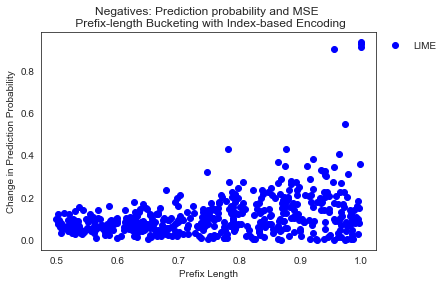

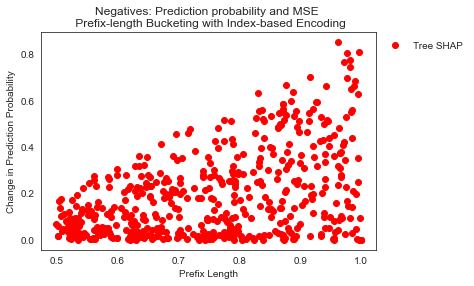

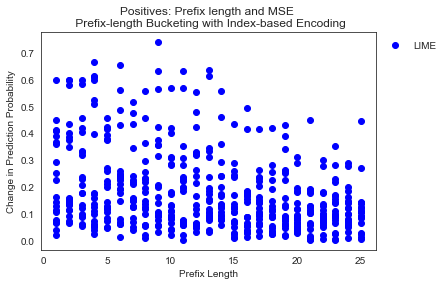

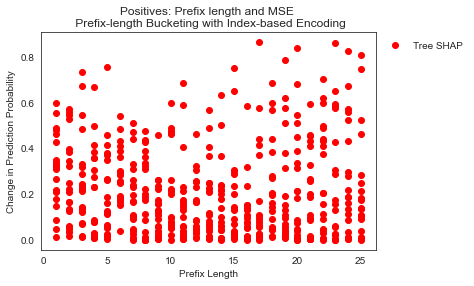

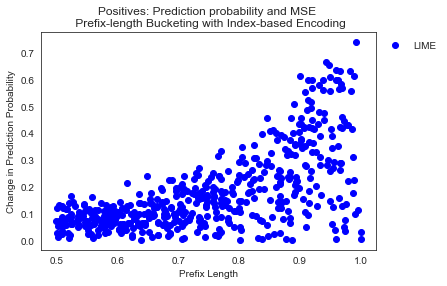

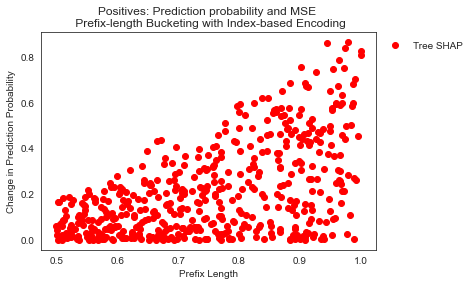

In [22]:
type_list = ['Negatives', 'Positives']

type_lengths = [[], []]
type_proba = [[],[]]

type_lengths[0].extend(sep_lengths[0])
type_lengths[0].extend(sep_lengths[2])
type_lengths[1].extend(sep_lengths[1])
type_lengths[1].extend(sep_lengths[3])

type_proba[0].extend(sep_proba[0])
type_proba[0].extend(sep_proba[2])
type_proba[1].extend(sep_proba[1])
type_proba[1].extend(sep_proba[3])

type_lime_MSE = [[],[]]
type_shap_MSE = [[],[]]

type_lime_MSE[0].extend(sep_lime_MSE[0])
type_lime_MSE[0].extend(sep_lime_MSE[2])
type_lime_MSE[1].extend(sep_lime_MSE[1])
type_lime_MSE[1].extend(sep_lime_MSE[3])

type_shap_MSE[0].extend(sep_shap_MSE[0])
type_shap_MSE[0].extend(sep_shap_MSE[2])
type_shap_MSE[1].extend(sep_shap_MSE[1])
type_shap_MSE[1].extend(sep_shap_MSE[3])

for i in range(len(type_list)):
    plt.plot(type_lengths[i], type_lime_MSE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_lengths[i], type_shap_MSE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_proba[i], type_lime_MSE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_proba[i], type_shap_MSE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

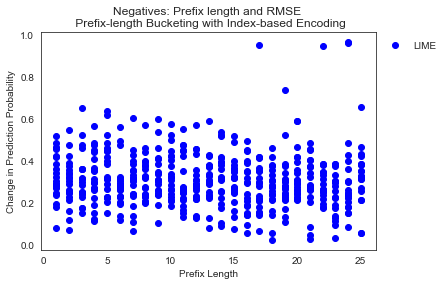

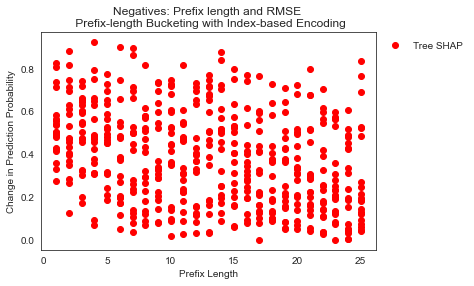

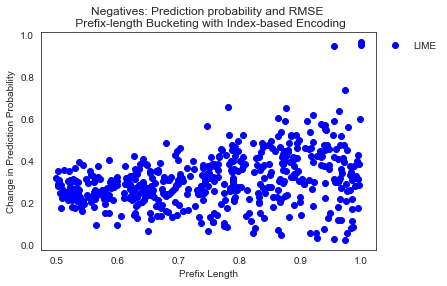

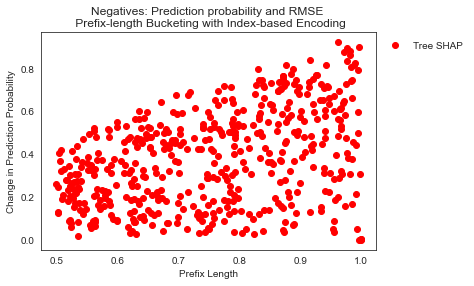

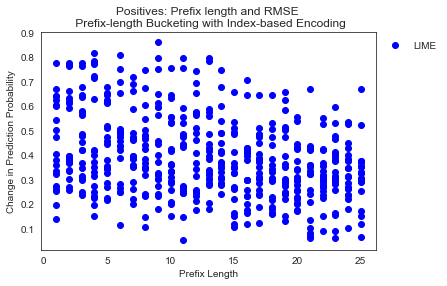

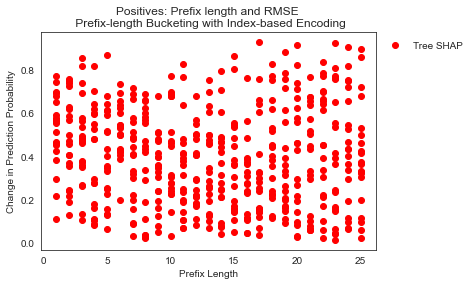

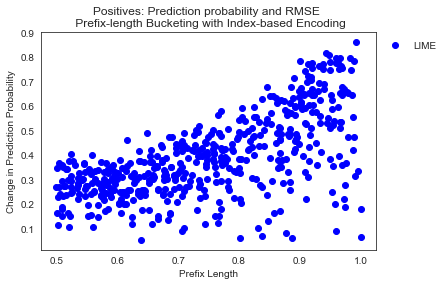

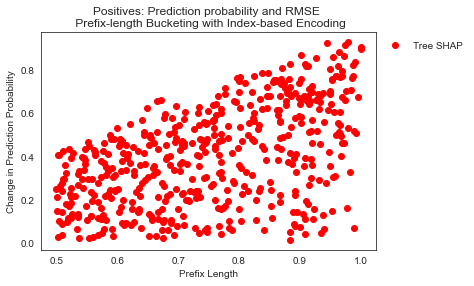

In [23]:
type_list = ['Negatives', 'Positives']

type_lengths = [[], []]
type_proba = [[],[]]

type_lengths[0].extend(sep_lengths[0])
type_lengths[0].extend(sep_lengths[2])
type_lengths[1].extend(sep_lengths[1])
type_lengths[1].extend(sep_lengths[3])

type_proba[0].extend(sep_proba[0])
type_proba[0].extend(sep_proba[2])
type_proba[1].extend(sep_proba[1])
type_proba[1].extend(sep_proba[3])

type_lime_RMSE = [[],[]]
type_shap_RMSE = [[],[]]

type_lime_RMSE[0].extend(sep_lime_RMSE[0])
type_lime_RMSE[0].extend(sep_lime_RMSE[2])
type_lime_RMSE[1].extend(sep_lime_RMSE[1])
type_lime_RMSE[1].extend(sep_lime_RMSE[3])

type_shap_RMSE[0].extend(sep_shap_RMSE[0])
type_shap_RMSE[0].extend(sep_shap_RMSE[2])
type_shap_RMSE[1].extend(sep_shap_RMSE[1])
type_shap_RMSE[1].extend(sep_shap_RMSE[3])

for i in range(len(type_list)):
    plt.plot(type_lengths[i], type_lime_RMSE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and RMSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_lengths[i], type_shap_RMSE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and RMSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_proba[i], type_lime_RMSE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and RMSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_proba[i], type_shap_RMSE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and RMSE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

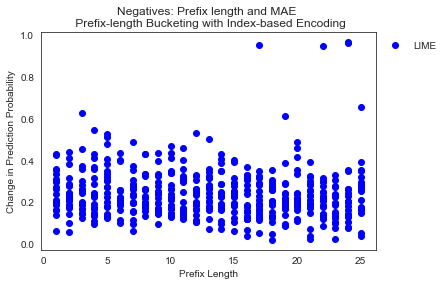

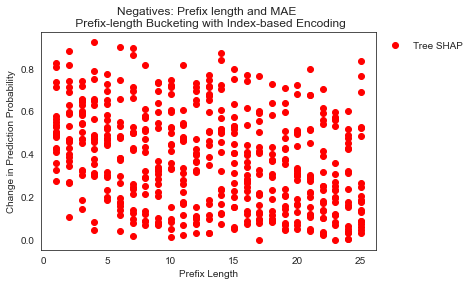

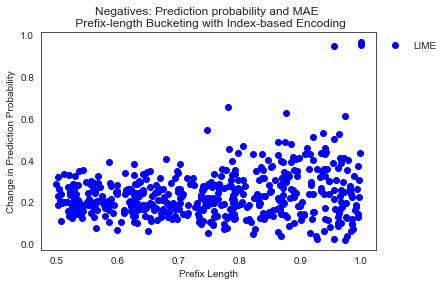

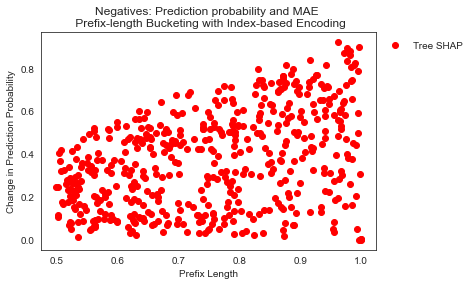

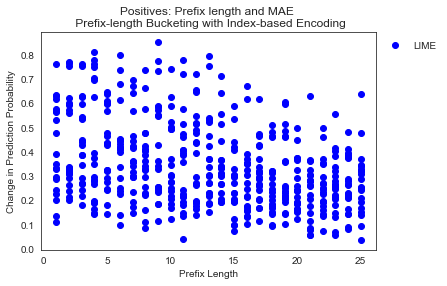

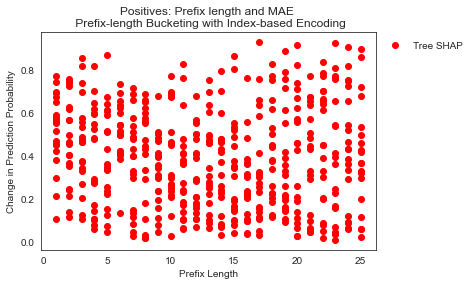

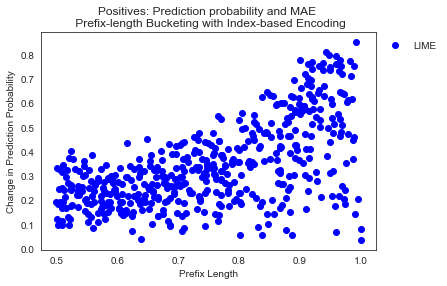

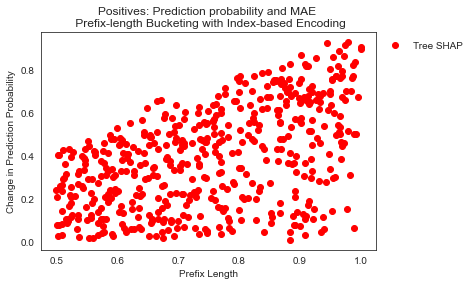

In [24]:
type_list = ['Negatives', 'Positives']

type_lengths = [[], []]
type_proba = [[],[]]

type_lengths[0].extend(sep_lengths[0])
type_lengths[0].extend(sep_lengths[2])
type_lengths[1].extend(sep_lengths[1])
type_lengths[1].extend(sep_lengths[3])

type_proba[0].extend(sep_proba[0])
type_proba[0].extend(sep_proba[2])
type_proba[1].extend(sep_proba[1])
type_proba[1].extend(sep_proba[3])

type_lime_MAE = [[],[]]
type_shap_MAE = [[],[]]

type_lime_MAE[0].extend(sep_lime_MAE[0])
type_lime_MAE[0].extend(sep_lime_MAE[2])
type_lime_MAE[1].extend(sep_lime_MAE[1])
type_lime_MAE[1].extend(sep_lime_MAE[3])

type_shap_MAE[0].extend(sep_shap_MAE[0])
type_shap_MAE[0].extend(sep_shap_MAE[2])
type_shap_MAE[1].extend(sep_shap_MAE[1])
type_shap_MAE[1].extend(sep_shap_MAE[3])

for i in range(len(type_list)):
    plt.plot(type_lengths[i], type_lime_MAE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MAE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_lengths[i], type_shap_MAE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MAE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_proba[i], type_lime_MAE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MAE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_proba[i], type_shap_MAE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MAE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

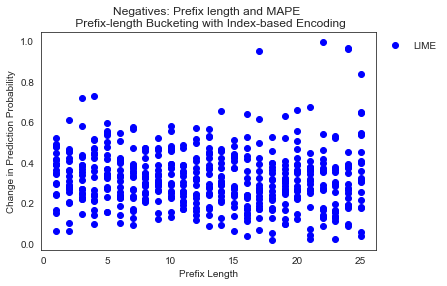

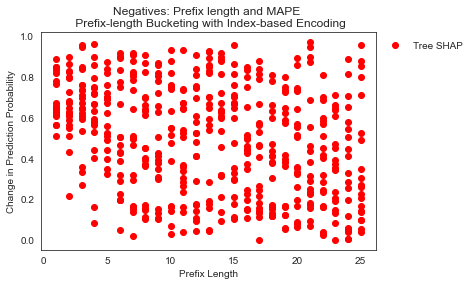

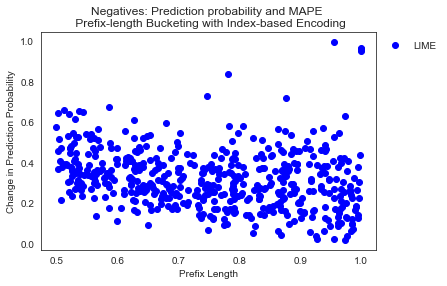

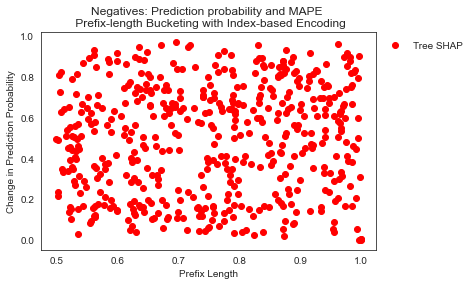

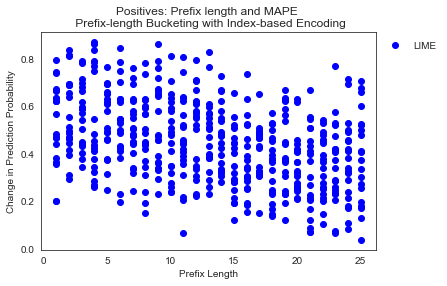

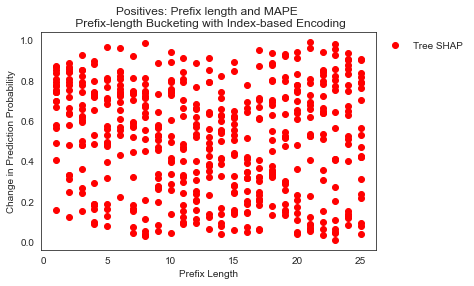

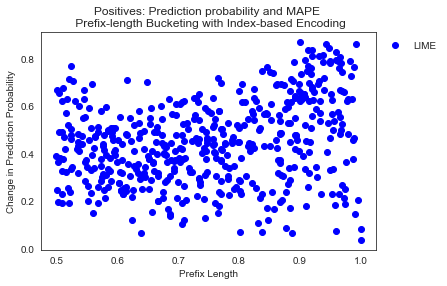

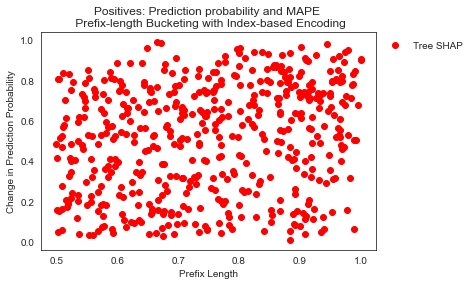

In [25]:
type_list = ['Negatives', 'Positives']

type_lengths = [[], []]
type_proba = [[],[]]

type_lengths[0].extend(sep_lengths[0])
type_lengths[0].extend(sep_lengths[2])
type_lengths[1].extend(sep_lengths[1])
type_lengths[1].extend(sep_lengths[3])

type_proba[0].extend(sep_proba[0])
type_proba[0].extend(sep_proba[2])
type_proba[1].extend(sep_proba[1])
type_proba[1].extend(sep_proba[3])

type_lime_MAPE = [[],[]]
type_shap_MAPE = [[],[]]

type_lime_MAPE[0].extend(sep_lime_MAPE[0])
type_lime_MAPE[0].extend(sep_lime_MAPE[2])
type_lime_MAPE[1].extend(sep_lime_MAPE[1])
type_lime_MAPE[1].extend(sep_lime_MAPE[3])

type_shap_MAPE[0].extend(sep_shap_MAPE[0])
type_shap_MAPE[0].extend(sep_shap_MAPE[2])
type_shap_MAPE[1].extend(sep_shap_MAPE[1])
type_shap_MAPE[1].extend(sep_shap_MAPE[3])

for i in range(len(type_list)):
    plt.plot(type_lengths[i], type_lime_MAPE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MAPE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_lengths[i], type_shap_MAPE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prefix length and MAPE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_proba[i], type_lime_MAPE[i], 'bo', label = "LIME")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MAPE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

    plt.plot(type_proba[i], type_shap_MAPE[i], 'ro', label = "Tree SHAP")
    plt.xlabel("Prefix Length")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+": Prediction probability and MAPE \n Prefix-length Bucketing with Index-based Encoding")
    plt.show()

In [26]:
print("Average LIME MSE:", np.mean(all_lime_MSE))
print("Average SHAP MSE:", np.mean(all_shap_MSE))
print("\n")

print("Average LIME RMSE:", np.mean(all_lime_RMSE))
print("Average SHAP RMSE:", np.mean(all_shap_RMSE))
print("\n")

print("Average LIME MAE:", np.mean(all_lime_MAE))
print("Average SHAP MAE:", np.mean(all_shap_MAE))
print("\n")

print("Average LIME MAPE:", np.mean(all_lime_MAPE))
print("Average SHAP MAPE:", np.mean(all_shap_MAPE))

Average LIME MSE: 0.14725250125703573
Average SHAP MSE: 0.20258575849261126


Average LIME RMSE: 0.350980277378392
Average SHAP RMSE: 0.3910438610435871


Average LIME MAE: 0.29092102462505576
Average SHAP MAE: 0.3843549524569477


Average LIME MAPE: 0.38582597698894483
Average SHAP MAPE: 0.5033385860315571
